In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import imageio
import sys
from collections import defaultdict

import random
from datetime import datetime
n_epi = 200
run_type = 'lifelong'
alpha = 0.5
epsilon = 0.01
n_steps = 100

act_dict = {
    "LEFT": 0,
    "DOWN": 1,
    "RIGHT": 2,
    "UP": 3,
    "PAUSE": 4,
}

In [2]:
def train_plot(agent, direction, epi_iter, epi_reward, n_epi = n_epi, run_type = run_type):
    fig, axs = plt.subplots(2)
    axs[0].set_title(f'{n_epi} Episodes and iterations - {agent}_{direction}')
    axs[0].set_xlabel('Number of episodes')
    axs[0].set_ylabel('Number of iterations')
    axs[1].set_title(f'{n_epi} Episodes and reward - {agent}_{direction}')
    axs[1].set_xlabel('Number of episodes')
    axs[1].set_ylabel('Reward')
    axs[0].plot(epi_iter)
    axs[1].plot(epi_reward)
    fig.tight_layout()

    plt.savefig(f'Plot/8x8_{n_epi} Episodes and iterations - {agent}_{direction}_{run_type}-method1.png', \
                bbox_inches='tight')


In [3]:
desc_file = open("map_8_8_v1.txt", "r") 
  
desc_content = desc_file.read() 

desc = desc_content.split("\n") 
desc = [d for d in desc if d!='']
desc_file.close() 
n_dim = len(desc[0])

# location of kitty, cat food, pet home, starting point, goal point
K_loc, C_loc, P_loc, S_loc, G_loc = list(), list(), list(), list(), list()

for i in range(len(desc)):
    if 'K' in desc[i]:
        K_loc.extend([i, desc[i].index('K')])
    if 'C' in desc[i]:
        C_loc.extend([i, desc[i].index('C')])
    if 'S' in desc[i]:
        S_loc.extend([i, desc[i].index('S')])
    if 'G' in desc[i]:
        G_loc.extend([i, desc[i].index('G')])

# kitty location is the same as pet home location initially
P_loc.extend([K_loc[0], K_loc[1]])
        

# locate holes 
H_loc_list = list()
for i in range(len(desc)):
    for d in range(len(desc[i])):
        if desc[i][d] == 'H':
            H_loc_list.append([i, d])

In [4]:
desc

['FFFFFFFH',
 'FFFFKGFF',
 'HHFFFHHF',
 'FFHFHHFF',
 'FFFFFFFF',
 'HCFFFFFF',
 'FFFFFFFF',
 'SFHFFFFH']

In [4]:
# remove S and G first and use P and C as starting point and goal to train kitty's Q-table
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'F'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'F'+desc[G_loc[0]][G_loc[1]+1:]
desc[P_loc[0]] = desc[P_loc[0]][:P_loc[1]]+'S'+desc[P_loc[0]][P_loc[1]+1:]
desc[C_loc[0]] = desc[C_loc[0]][:C_loc[1]]+'G'+desc[C_loc[0]][C_loc[1]+1:]

# env that the kitty heading for food
kitty_env_food = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

In [5]:
def epsilon_greedy(env, epsilon, num_act, Q):
    """
    return a function to compute probability of choosing each action on the given state
    """
    def policy_s(state):
        action_probs = np.full(num_act,epsilon/num_act)
        a = np.argmax(Q[state])
        action_probs[a] += (1-epsilon)
        
        return action_probs
    return policy_s



def Q_learning_kitty(env, num_episodes = n_epi, discount_factor = 1.0, alpha = alpha, epsilon = epsilon):

    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # initialize Q-value
    # get num of actions
    nA = env.action_space.n
    policy = epsilon_greedy(env, epsilon, nA, Q)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):

        if (i_epi+1) %100 == 0:
            print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        # initialize state    
        state = env.reset()[0]
        num_iter = 1
        
        while True:
            act_probs = policy(state)
            # randomly choose an action following probability in act_probs
            action = np.random.choice(len(act_probs), p = act_probs)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_next_Q = max(Q[next_state])
            Q[state][action] += alpha *(reward + discount_factor * max_next_Q - Q[state][action])
            
            episode_iterations[i_epi] = num_iter+1
            episode_reward[i_epi] += reward
            
            if terminated:
                break
            
            state = next_state
            num_iter += 1
        
    return Q, episode_iterations, episode_reward
     
Q_kitty_food, episode_iterations_kitty_food, episode_reward_kitty_food = Q_learning_kitty(kitty_env_food)

Episode: 200

In [6]:
# use P and C as goal and starting point to train kitty's Q-table
# for case that the kitty is heading for pet home

desc[P_loc[0]] = desc[P_loc[0]][:P_loc[1]]+'G'+desc[P_loc[0]][P_loc[1]+1:]
desc[C_loc[0]] = desc[C_loc[0]][:C_loc[1]]+'S'+desc[C_loc[0]][C_loc[1]+1:]

# env that the kitty heading for home
kitty_env_home = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

Q_kitty_home, episode_iterations_kitty_home, episode_reward_kitty_home = Q_learning_kitty(kitty_env_home)

Episode: 200

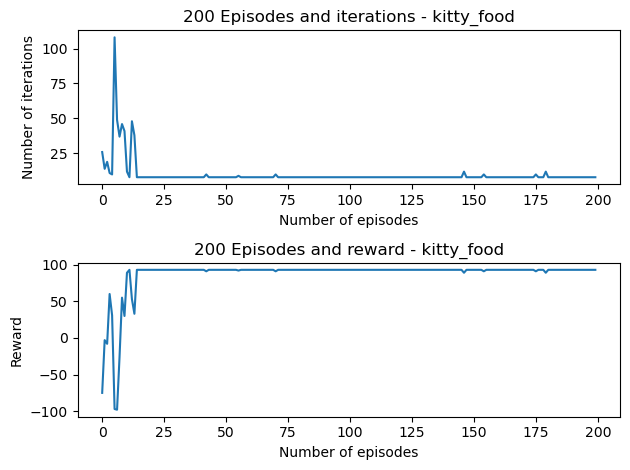

In [7]:
# plot training statistics for kitty
train_plot('kitty', 'food', episode_iterations_kitty_food, episode_reward_kitty_food)


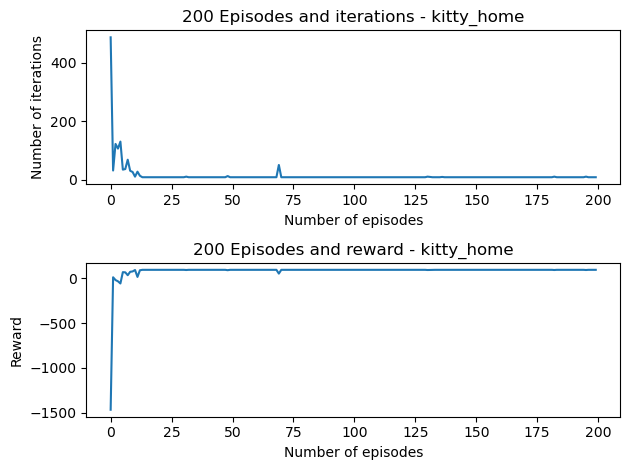

In [8]:
train_plot('kitty', 'home', episode_iterations_kitty_home, episode_reward_kitty_home)


In [9]:
kitty_info = {
    'k': K_loc,
    'home': P_loc, 
    # if kitty is seeking food or home. True for food
    'if_food' : True,
    'food' : C_loc,
    'holes' : H_loc_list,
    'start' : S_loc,
    'goal' : G_loc,
    }

def kitty_move(env, kitty, num_dim, Q_k_food, Q_k_home, num_k_box):
    
    env, kitty = to_original_component(env, kitty)
    # compute kitty's state
    k_state = kitty['k'][0] * num_dim + kitty['k'][1] 
    
    if kitty['if_food']: # if heading for food
        # compute kitty's action based on the Q-table
        k_act = np.argmax(Q_k_food[k_state])
    else:
        k_act = np.argmax(Q_k_home[k_state])
        
    if k_act == 0: # LEFT
        kitty['k'][1] = max(kitty['k'][1]-1, 0)
    elif k_act ==1: # DOWN
        kitty['k'][0] = min(kitty['k'][0]+1, num_dim -1)
    elif k_act == 2: # RIGHT
        kitty['k'][1] = min(kitty['k'][1]+1, num_dim -1)
    elif k_act ==3: # UP
        kitty['k'][0] = max(kitty['k'][0]-1, 0)

    env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
    
    # update kitty's direction if needed
    if kitty['k'][0] == kitty['food'][0] and kitty['k'][1] == kitty['food'][1]:
        kitty['if_food'] = False # once reach food, head for home
        num_k_box += 1 # number of boxes delivered by kitty +1
    elif kitty['k'][0] == kitty['home'][0] and kitty['k'][1] == kitty['home'][1]:
        kitty['if_food'] = True # once reach home, head for food
    return env, kitty, num_k_box


def to_original_component(env, kitty):
    # change kitty's current location to the original component
    if kitty['k'] == kitty['food']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'C'
    elif kitty['k'] in kitty['holes']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'H'
    elif kitty['k'] == kitty['start']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'S'
    elif kitty['k'] == kitty['goal']:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'G'
    elif kitty['k'] == kitty['home']:    
        env.desc[kitty['k'][0], kitty['k'][1]] = b'P'
    else:
        env.desc[kitty['k'][0], kitty['k'][1]] = b'F'
    return env, kitty



In [10]:
# put S, G, K, C back to train elf's Q-table when elf is heading to goal
# pet home is coverred by kitty initially
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'S'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'G'+desc[G_loc[0]][G_loc[1]+1:]
desc[P_loc[0]] = desc[P_loc[0]][:P_loc[1]]+'K'+desc[P_loc[0]][P_loc[1]+1:]
#desc[K_loc[0]] = desc[K_loc[0]][:K_loc[1]]+'K'+desc[K_loc[0]][K_loc[1]+1:]
desc[C_loc[0]] = desc[C_loc[0]][:C_loc[1]]+'C'+desc[C_loc[0]][C_loc[1]+1:]

# env where the elf is heading for goal
env_g = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')



def Q_learning(env, kitty, num_episodes = n_epi, Q_k_food = Q_kitty_food, Q_k_home = Q_kitty_home, \
               num_dim = n_dim, discount_factor = 1.0, alpha = alpha, epsilon = epsilon):
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) # initialize Q-value
    # get num of actions
    nA = env.action_space.n
    policy = epsilon_greedy(env, epsilon, nA, Q)
    
    # to record for each record, how many iterations it takes to reach termination
    episode_iterations = np.zeros(num_episodes)
    # to record for each record, how much reward it got eventually
    episode_reward = np.zeros(num_episodes)
    
    for i_epi in range(num_episodes):

        if (i_epi+1) %100 == 0:
            print("\rEpisode: {}".format(i_epi+1), flush = True, end="")
        # initialize elf's state    
        state = env.reset()[0]
        
        # convert current location of kitty to its original component
        env, kitty = to_original_component(env, kitty)
        
        # reset kitty's location to kitty's home for each episode
        kitty['k'][0], kitty['k'][1] = kitty['home'][0], kitty['home'][1]  
        env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
        env.desc[kitty['food'][0], kitty['food'][1]] = b'C'
        
        num_iter = 1
        num_k_box = 0
        
        
        while True:
            # choose kitty's action based on kitty's Q table first
            env, kitty, num_k_box = kitty_move(env, kitty, num_dim, Q_k_food, Q_k_home, num_k_box)
            
            act_probs = policy(state)
            # randomly choose an action following probability in act_probs
            action = np.random.choice(len(act_probs), p = act_probs)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            max_next_Q = max(Q[next_state])
            Q[state][action] += alpha *(reward + discount_factor * max_next_Q - Q[state][action])
            
            episode_iterations[i_epi] = num_iter+1
            episode_reward[i_epi] += reward
            
            if terminated:
                break
            
            state = next_state
            num_iter += 1
        
    return Q, episode_iterations, episode_reward



Q_g, episode_iterations_g, episode_reward_g = Q_learning(env_g, kitty=kitty_info)

Episode: 200

In [11]:
# Reverse S, G to train elf's Q-table when elf is heading to starting point
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'G'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'S'+desc[G_loc[0]][G_loc[1]+1:]
# env where the elf is heading for starting point
env_s = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

Q_s, episode_iterations_s, episode_reward_s = Q_learning(env_s, kitty=kitty_info)

Episode: 200

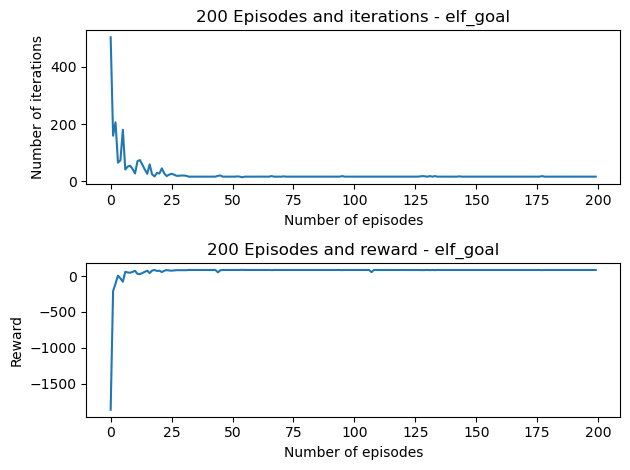

In [12]:
train_plot('elf', 'goal', episode_iterations_g, episode_reward_g)

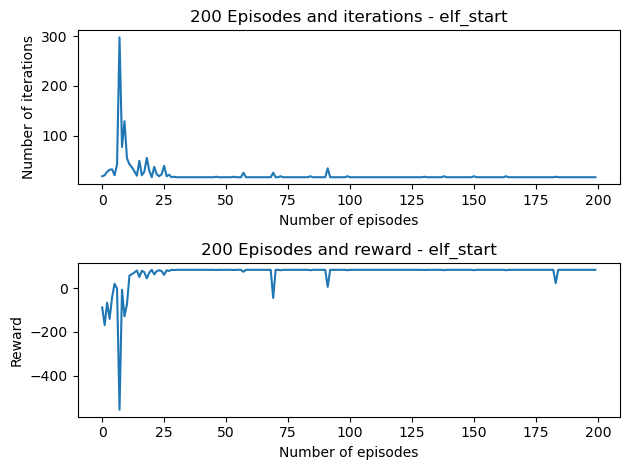

In [13]:
train_plot('elf', 'start', episode_iterations_s, episode_reward_s)

In [14]:
# Reverse S, G back to build testing env
desc[S_loc[0]] = desc[S_loc[0]][:S_loc[1]]+'S'+desc[S_loc[0]][S_loc[1]+1:]
desc[G_loc[0]] = desc[G_loc[0]][:G_loc[1]]+'G'+desc[G_loc[0]][G_loc[1]+1:]

env = gym.make('FrozenLake-v1', desc=desc, is_slippery=False, render_mode = 'rgb_array')

# calculate state of S and G
S_state = S_loc[0] * n_dim + S_loc[1]
G_state = G_loc[0] * n_dim + G_loc[1]

# modify goal point at testing env
# so that next state is affected by actions on goal point
# and get reward if moving from goal point
for a in range(env.action_space.n):
    t_p_G = env_s.P[G_state][a][0]
    goal_next_state = t_p_G[1]
    if goal_next_state == G_state:
        # if next state on state G is still state G, then terminated is True
        # but prob, next_state, reward are the same as env_s.P[G_state][a][0]
        env.P[G_state][a][0] = (t_p_G[0], t_p_G[1], t_p_G[2], True)
    else:
        # prob, next_state, reward, terminated are the same as env_s.P[G_state][a][0]
        env.P[G_state][a][0] = t_p_G

def reverse_terminated(st, terminate_val, env = env, num_dim = n_dim):
    """
    Args: st: S_state or G_state. Change S_state to a destination, then st = True and terminate_val = True
    terminate_val: True or False. The updated value of terminated
    """
    # if next state of a state when taking action a is st,
    # reverse "terminated" at the state when taking action a to True or False
    if (st - num_dim) in env.P.keys(): # the state  which take "DOWN" can reach st
        env_P_val = env.P[st - num_dim][act_dict["DOWN"]][0]
        env.P[st - num_dim][act_dict["DOWN"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st + num_dim) in env.P.keys(): # the state  which take "UP" can reach st
        env_P_val = env.P[st + num_dim][act_dict["UP"]][0]
        env.P[st + num_dim][act_dict["UP"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st -1) in env.P.keys(): # the state  which take "RIGHT" can reach st
        env_P_val = env.P[st -1][act_dict["RIGHT"]][0]
        env.P[st - 1][act_dict["RIGHT"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    if (st +1) in env.P.keys(): # the state  which take "LEFT" can reach st
        env_P_val = env.P[st + 1][act_dict["LEFT"]][0]
        env.P[st + 1][act_dict["LEFT"]][0] = (env_P_val[0], env_P_val[1], env_P_val[2], terminate_val)
    # if next state of st when taking action a is the same as st
    # next state of taking action a on S leads to terminated == terminate_val
    for a in range(env.action_space.n):
        t_p_S = env.P[st][a][0]
        if t_p_S[1] == st: 
            env.P[st][a][0] = (t_p_S[0], t_p_S[1], t_p_S[2], terminate_val) 
                
    return env

# datetime object containing current date and time
now = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
file_name = f"Demo/epi_{n_epi}/kitty_qlearning-{n_dim}x{n_dim}map_{run_type}_{now}.gif"


def Demo_GIF(kitty, env = env, Q_k_food = Q_kitty_food, Q_k_home = Q_kitty_home, \
                     Q_g = Q_g, Q_s = Q_s, num_dim = n_dim, address = file_name, \
                     S_state = S_state, G_state = G_state, num_steps = n_steps):
    
    pics = []
    # starting at elf heading for goal
    state = env.reset()[0]
    
    env, kitty = to_original_component(env, kitty)
    
    if_goal = True # direction of elf. True when heading for goal. False when heading for starting point
    
    # reset kitty's location 
    kitty['k'][0], kitty['k'][1] = kitty['home'][0], kitty['home'][1]  
    env.desc[kitty['k'][0], kitty['k'][1]] = b'K'
    env.desc[kitty['food'][0], kitty['food'][1]] = b'C'
    
    num_collision = 0
    
    num_k_box = 0 # num of boxes delivered by kitty
    num_e_box = 0 # num of boxes delivered by elf
    
    for i in range(num_steps):
        pics.append(env.render())
        
        # choose kitty's action based on kitty's Q table first
        env, kitty, num_k_box = kitty_move(env, kitty, num_dim, Q_k_food, Q_k_home, num_k_box)
            
        if if_goal == True:
            # choose elf's action based on Q-table when heading to goal
            action = np.argmax(Q_g[state]) 
            next_state, reward, terminated, truncated, info = env.step(action)

            if terminated:
                # number of boxes delivered by elf +1
                num_e_box +=1
                
                # reverse direction
                if_goal= False     
                
                # S is now the destination
                env = reverse_terminated(S_state, terminate_val = True, env = env)
                
                # G is now the starting point
                env = reverse_terminated(G_state, terminate_val = False, env = env)
    
        elif if_goal == False:
            # choose elf's action based on Q-table when heading to starting point
            action = np.argmax(Q_s[state])
            next_state, reward, terminated, truncated, info = env.step(action)
           
            if terminated:
                
                # reverse direction
                if_goal= True
                # S is now the destination
                env = reverse_terminated(S_state, terminate_val = False, env = env)
                
                # G is now the starting point
                env = reverse_terminated(G_state, terminate_val = True, env = env)
                    
        state = next_state
        
        k_state = kitty['k'][0] * num_dim + kitty['k'][1]
        if k_state == state: # if kitty's state == elf's state, number of collision +1
            num_collision += 1
    
    print(f'Number of collisions in {num_steps} steps when episode number is {n_epi}:', num_collision)
    print(f'Number of boxes delivered by kitty:', num_k_box)
    print(f'Number of boxes delivered by elf:', num_e_box)
    print(f'Total number of boxes delivered:', (num_k_box+num_e_box))
    print(f'Demo GIF is: {file_name}')
    
    pics.append(env.render())
    env.close()

    imageio.mimsave(address, pics)



In [15]:
%%time
Demo_GIF(kitty_info)

Number of collisions in 100 steps when episode number is 200: 3
Number of boxes delivered by kitty: 7
Number of boxes delivered by elf: 3
Total number of boxes delivered: 10
Demo GIF is: Demo/epi_200/kitty_qlearning-8x8map_lifelong_26-05-2024 18_47_23.gif
CPU times: user 3.12 s, sys: 139 ms, total: 3.26 s
Wall time: 3.56 s
